In [1]:
import cooler
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
%matplotlib inline

In [43]:
mtx = c.matrix(as_pixels=True, balance=False, sparse=False).fetch("chrX")

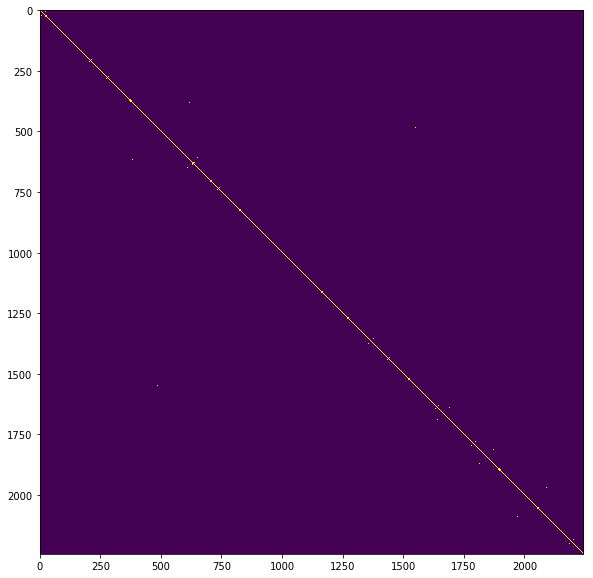

In [2]:
c = cooler.Cooler('../../DATA/dm3/COOL_MODEL/A2.chrX.10.cool')
mtx = c.matrix(as_pixels=False, balance=False, sparse=False).fetch("chrX")
plt.figure(figsize=(10,10))
plt.imshow(mtx[:,:].astype(np.bool))
plt.plot()

In [3]:
magn_f = 10*1e3

mtx = c.matrix(as_pixels=True, balance=False, sparse=False).fetch("chrX")
#mtx[mtx['count'] > 1]
print mtx.bin1_id.max() * 10
coord1 = mtx['bin1_id'].apply(lambda x: int((magn_f * (x + 1) + magn_f * x) / 2))
coord2 = mtx['bin2_id'].apply(lambda x: int((magn_f * (x + 1) + magn_f * x) / 2))

#coord1 = mtx['bin1_id'].apply(lambda x: int(magn_f * x))
#coord2 = mtx['bin2_id'].apply(lambda x: int(magn_f * x))

#chrom1\tcoord1\tchrom2\tcoord2\n

data = {'chrom1': ['X']*len(coord2),'coord1': coord1.values, 'chrom2': ['X']*len(coord2),'coord2': coord2.values}
df = pd.DataFrame(data, columns=['chrom1','coord1', 'chrom2', 'coord2'])
df = df[df['coord2'] != 22425000]

print df
with open('../data/test.txt', 'w') as f:
    f.write(df.to_csv(index=False, sep='\t'))


22420
     chrom1    coord1 chrom2    coord2
0         X      5000      X      5000
1         X      5000      X     15000
2         X      5000      X     25000
4         X     15000      X     15000
5         X     15000      X     25000
7         X     25000      X     25000
8         X     25000      X     35000
10        X     35000      X     35000
11        X     35000      X     45000
13        X     45000      X     45000
14        X     45000      X     55000
16        X     55000      X     55000
17        X     55000      X     65000
19        X     65000      X     65000
20        X     65000      X     75000
21        X     65000      X    225000
22        X     65000      X    255000
24        X     75000      X     75000
25        X     75000      X     85000
27        X     85000      X     85000
28        X     85000      X     95000
30        X     95000      X     95000
31        X     95000      X    105000
33        X    105000      X    105000
34        X    1050

In [5]:
with open('../data/GSM1173493_cell-1.txt', 'r') as f:
    ref = f.readlines()
    
#print ref

In [15]:
"""
This script sets up the posterior probability of the structure of
the X chromosome based on single-cell Hi-C contact data. 
"""
from isdhic import HiCParser
from isdhic.chromosome import ChromosomeSimulation

## Each bead represents 50 Kb of chromatin and has a diameter of
## roughly 200 nm (assuming a chromatin density of 12 Mb / mu^3)

resolution  =     500 * 1e3
chrsize     = 22420 * 1e3
n_particles = int(chrsize / resolution)

## Linearly ramped Lennard-Jones potential preventing inter-bead
## clashes. The bead diameter is 4 and chosen for compatibility with
## settings used in protein simulations

forcefield  = 'rosetta'
diameter    = 4.

## Single-cell Hi-C data from Nagano et al., the contact distance
## is factor x diameter which equals to 6. Data are from cell 1

filename    = '../data/test.txt'
factor      = 1.5

## Beads-on-string-model: consecutive beads are connected by a
## harmonic potential with a flat bottom. The harmonic force
## becomes active when the distance between beads (i, i+1) exceeds
## the bead diameter. The force constant controls the strength of
## that force

k_backbone  = 250.

## Radius of gyration (rog) restraint derived from FISH data. The
## size of the X chromosome is roughly 2.58 x rog. Nagano et al.
## determined a size of 3.7 +/- 0.3 mu based on 10 FISH measurements

n_rog       = 10
mu_rog      = 3.7e3 / (2.58 * (resolution / 1200) / diameter)
sigma_rog   = 0.3e3 / (2.58 * (resolution / 1200) / diameter)
tau_rog     = n_rog / sigma_rog**2

## Read data and map chromosomal positions onto 500Kb beads and
## remove contacts arising from loci that are close in sequence and
## were mapped to the same bead.

parser      = HiCParser(filename, 'X', 'X')
datasets    = parser.parse()
dataset     = datasets[('X','X')]
model       = ('logistic', 'relu')[0]

dataset.coarsen(n_particles, chrsize)

dataset.remove_redundant_contacts()
dataset.remove_self_contacts()

## Set up posterior probability using the above settings

simulation  = ChromosomeSimulation(n_particles,
                                   forcefield = forcefield,
                                   k_backbone = k_backbone,
                                   diameter   = diameter,
                                   factor     = factor,
                                   contact_model = model)

posterior = simulation.create_chromosome(list(dataset))
universe  = simulation.universe
coords    = simulation.params['coordinates']
forces    = simulation.params['forces']

posterior['rog'].data[0] = mu_rog
posterior['rog'].tau     = tau_rog

In [13]:
print posterior['contacts'].alpha
print len(dataset.data)
print dataset.data 

100.0
124
[(1, 13), (1, 2), (2, 8), (2, 4), (2, 5), (2, 3), (2, 6), (3, 8), (3, 30), (3, 4), (3, 6), (3, 22), (3, 5), (3, 11), (4, 33), (4, 6), (4, 12), (4, 30), (4, 8), (4, 10), (4, 9), (4, 5), (5, 6), (6, 30), (6, 8), (6, 9), (6, 12), (6, 7), (7, 12), (7, 13), (7, 8), (7, 19), (7, 37), (7, 17), (8, 26), (8, 30), (8, 37), (8, 12), (8, 10), (9, 11), (9, 30), (9, 10), (10, 11), (10, 12), (11, 33), (11, 30), (11, 12), (11, 37), (12, 37), (12, 38), (12, 14), (12, 13), (12, 17), (13, 19), (13, 17), (13, 14), (14, 34), (14, 15), (15, 18), (15, 41), (15, 22), (15, 16), (16, 20), (16, 17), (17, 22), (17, 18), (18, 19), (19, 20), (19, 41), (20, 40), (20, 41), (20, 23), (20, 21), (21, 23), (21, 27), (21, 39), (22, 33), (22, 27), (23, 26), (23, 40), (23, 27), (23, 24), (24, 25), (25, 41), (25, 38), (25, 40), (25, 29), (26, 38), (26, 31), (26, 28), (26, 32), (26, 34), (26, 37), (26, 27), (26, 29), (27, 28), (27, 33), (28, 33), (28, 31), (28, 38), (28, 29), (28, 32), (29, 33), (29, 31), (29, 30), 

In [16]:
"""
Inferential structure determination of the X chromosome at 500 kb resolution
using Hamiltonian Monte Carlo.
"""
import sys
import isdhic
import numpy as np

from isdhic.core import take_time

from scipy import optimize

class HamiltonianMonteCarlo(isdhic.HamiltonianMonteCarlo):

    def next(self):

        result = super(HamiltonianMonteCarlo, self).next()

        if len(self.history) and not len(self.history) % 20:
            print '{0}, stepsize = {1:.3e}, -log_prob = {2:.3e}'.format(
                self.history, self.stepsize, self.state.potential_energy)

        return result

if __name__ == '__main__':

    ## set up X chromosome simulation at 500 kb / 50 kb resolution

    #resolution = 500  
    #filename   = './chrX_cell1_{0}kb.py'.format(resolution)

    #with open(filename) as script:
    #    exec script

    ## start from stretched out chromosome structure

    extended = np.multiply.outer(np.arange(n_particles), np.eye(3)[0]) * diameter
    coords.set(extended)

    ## use Hamiltonian Monte Carlo to sample X chromosome structures from the
    ## posterior distribution

    n_steps  = 1e3                                    ## number of HMC iterations
    n_leaps  = 1e2                                    ## number of leapfrog integration steps
    stepsize = 1e-3                                   ## initial integration stepsize
    
    hmc = HamiltonianMonteCarlo(posterior,stepsize=stepsize)
    hmc.leapfrog.n_steps = int(n_leaps)
    hmc.adapt_until      = int(0.5 * n_steps) * 10
    hmc.activate()

    posterior['contacts'].alpha = 100.
    hmc.stepsize = 1e-3
    
    samples = []

    counter = 0
    with take_time('running HMC'):
        while counter < n_steps:
            samples.append(next(hmc))
            counter += 1

n_steps = 20, acceptance rate = 100.0%, stepsize = 2.653e-03, -log_prob = 2.197e+04
n_steps = 40, acceptance rate = 95.0%, stepsize = 5.885e-03, -log_prob = 3.703e+02
n_steps = 60, acceptance rate = 93.3%, stepsize = 1.305e-02, -log_prob = 3.634e+02
n_steps = 80, acceptance rate = 83.8%, stepsize = 1.546e-02, -log_prob = 3.238e+02
n_steps = 100, acceptance rate = 75.0%, stepsize = 1.400e-02, -log_prob = 3.184e+02
n_steps = 120, acceptance rate = 70.8%, stepsize = 1.516e-02, -log_prob = 3.218e+02
n_steps = 140, acceptance rate = 67.9%, stepsize = 1.641e-02, -log_prob = 3.213e+02
n_steps = 160, acceptance rate = 65.0%, stepsize = 1.625e-02, -log_prob = 3.154e+02
n_steps = 180, acceptance rate = 62.2%, stepsize = 1.471e-02, -log_prob = 3.245e+02
n_steps = 200, acceptance rate = 60.5%, stepsize = 1.457e-02, -log_prob = 3.212e+02
n_steps = 220, acceptance rate = 58.6%, stepsize = 1.319e-02, -log_prob = 3.323e+02
n_steps = 240, acceptance rate = 58.3%, stepsize = 1.562e-02, -log_prob = 3.286

In [7]:
print len(set(dataset.data))

124


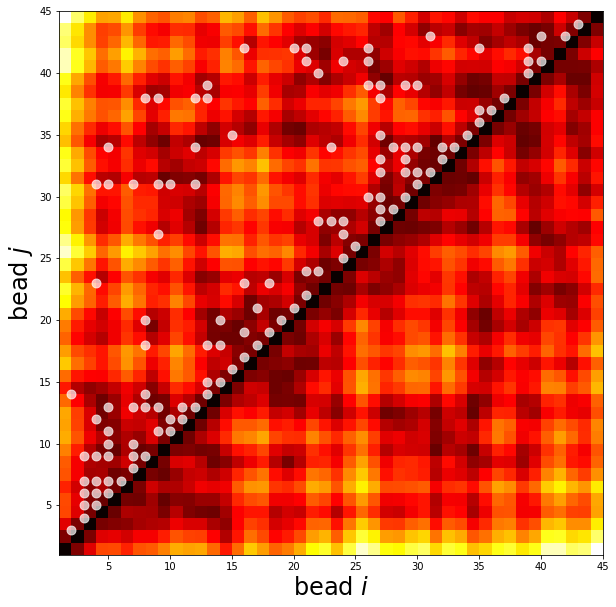

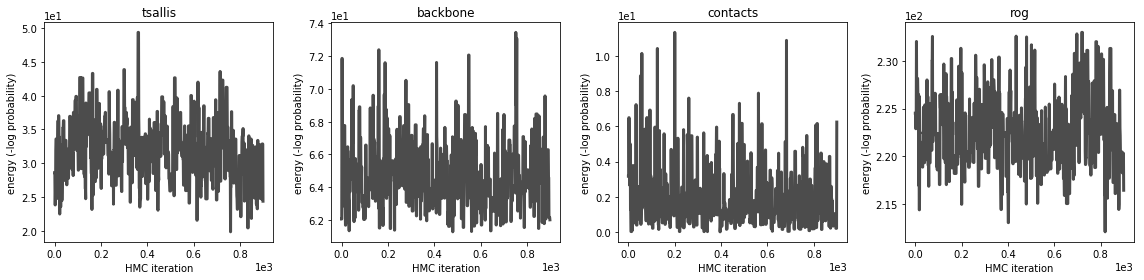

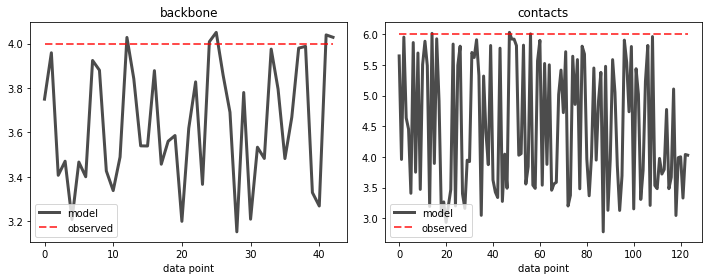

In [17]:
"""
Some classes and functions for analysing chromosome conformations generated with
Hamiltonian Monte Carlo.
"""
import numpy as np
import pylab as plt
import matplotlib.cm as cm

from isdhic import utils
from csb.bio.utils import distance_matrix

from collections import OrderedDict

class Ensemble(object):

    def __init__(self, samples):

        self.samples = samples

    def average_distances(self, burnin=0, thining=1):
        
        d = 0.
        n = 0
        for x in self.samples[burnin::thining]:
            d += distance_matrix(x)
            n += 1
        d/= n

        return d

    def calculate_energies(self, posterior, burnin=0, thining=1):

        energies = OrderedDict()
        for p in posterior: energies[p.name] = []
        
        coords = posterior.params['coordinates']
        
        for x in self.samples[burnin::thining]:

            coords.set(x)
            posterior.update()

            for p in posterior: energies[p.name].append(-p.log_prob())

        for name in energies: energies[name] = np.array(energies[name])

        return energies

if __name__ == '__main__':
    
    #pymol = utils.ChainViewer()

    X = np.array([state.positions for state in samples]).reshape(len(samples),-1,3)
    V = np.array([state.potential_energy for state in samples])
    K = np.array([state.kinetic_energy for state in samples])

    ensemble = Ensemble(X)

    ## show distance matrix and superimpose contacts

    n_particles = X.shape[1]
    limits = (1,n_particles+1)

    burnin, thining = -500, 10
    burnin, thining = -100, 1
    
    fig, ax = plt.subplots(1,1,figsize=(10,10),subplot_kw=dict(xlim=limits,ylim=limits))
    ax.matshow(ensemble.average_distances(burnin,thining), cmap=cm.hot, origin='lower',extent=limits+limits)
    ax.scatter(*(1+np.transpose(list(posterior['contacts'].mock.pairs))), color='w', alpha=0.7, s=80)
    ax.xaxis.set_ticks_position('bottom')
    ax.set_xlabel(r'bead $i$', fontsize=24)
    ax.set_ylabel(r'bead $j$', fontsize=24)
    
    ## calculate energies and plot energy traces

    energies = ensemble.calculate_energies(posterior,burnin=100)

    fig, ax = plt.subplots(1,len(energies),figsize=(16,4), subplot_kw=dict(xlabel='HMC iteration'))

    for i, name in enumerate(energies.keys()):
        ax[i].plot(energies[name],color='k',lw=3,alpha=0.7)
        ax[i].set_ylabel('energy (-log probability)')
        ax[i].set_title(name)
        ax[i].xaxis.get_major_formatter().set_powerlimits((0, 1))
        ax[i].yaxis.get_major_formatter().set_powerlimits((0, 1))
        
    fig.tight_layout()

    ## plot observed and backcalculated data

    models = [model for model in posterior.likelihoods if len(model.data) > 1]

    fig, ax = plt.subplots(1,len(models),figsize=(10,4), subplot_kw=dict(xlabel='data point'))

    for i, model in enumerate(models):
        ax[i].plot(model.mock.get(),color='k',lw=3,alpha=0.7,label='model')
        ax[i].plot(model.data,color='r',lw=2,ls='--',alpha=0.7,label='observed')
        ax[i].set_title(model.name)
        ax[i].legend(loc=3)
        
    fig.tight_layout()

In [18]:
pymol = utils.ChainViewer()
pymol(X)

In [19]:
"""
This script sets up the posterior probability of the structure of
the X chromosome based on single-cell Hi-C contact data. 
"""
from isdhic import HiCParser
from isdhic.chromosome import ChromosomeSimulation

## Each bead represents 50 Kb of chromatin and has a diameter of
## roughly 200 nm (assuming a chromatin density of 12 Mb / mu^3)

resolution  =     50 * 1e3
chrsize     = 22420 * 1e3
n_particles = int(chrsize / resolution)

## Linearly ramped Lennard-Jones potential preventing inter-bead
## clashes. The bead diameter is 4 and chosen for compatibility with
## settings used in protein simulations

forcefield  = 'rosetta'
diameter    = 4.

## Single-cell Hi-C data from Nagano et al., the contact distance
## is factor x diameter which equals to 6. Data are from cell 1

filename    = '../data/test.txt'
factor      = 1.5

## Beads-on-string-model: consecutive beads are connected by a
## harmonic potential with a flat bottom. The harmonic force
## becomes active when the distance between beads (i, i+1) exceeds
## the bead diameter. The force constant controls the strength of
## that force

k_backbone  = 250.

## Radius of gyration (rog) restraint derived from FISH data. The
## size of the X chromosome is roughly 2.58 x rog. Nagano et al.
## determined a size of 3.7 +/- 0.3 mu based on 10 FISH measurements

n_rog       = 10
mu_rog      = 3.7e3 / (2.58 * (resolution / 1200) / diameter)
sigma_rog   = 0.3e3 / (2.58 * (resolution / 1200) / diameter)
tau_rog     = n_rog / sigma_rog**2

## Read data and map chromosomal positions onto 500Kb beads and
## remove contacts arising from loci that are close in sequence and
## were mapped to the same bead.

parser      = HiCParser(filename, 'X', 'X')
datasets    = parser.parse()
dataset     = datasets[('X','X')]
model       = ('logistic', 'relu')[0]

dataset.coarsen(n_particles, chrsize)

dataset.remove_redundant_contacts()
dataset.remove_self_contacts()

## Set up posterior probability using the above settings

simulation  = ChromosomeSimulation(n_particles,
                                   forcefield = forcefield,
                                   k_backbone = k_backbone,
                                   diameter   = diameter,
                                   factor     = factor,
                                   contact_model = model)

posterior = simulation.create_chromosome(list(dataset))
universe  = simulation.universe
coords    = simulation.params['coordinates']
forces    = simulation.params['forces']

posterior['rog'].data[0] = mu_rog
posterior['rog'].tau     = tau_rog

In [20]:
"""
Continue HMC sampling at higher resolution.

This script assumes that 'run_hmc.py' has already been executed in
the *same* python session.
"""
import numpy as np

from scipy import interpolate

def lift_coords(coarse_coords, n_fine):
    """
    Interpolate 3d fiber with a finer sampling.
    """
    tck, u = interpolate.splprep(np.reshape(coarse_coords,(-1,3)).T)    
    coords = interpolate.splev(np.linspace(0,1,n_fine), tck)

    return np.transpose(coords).flatten()

if __name__ == '__main__':
    
    #resolution = 50
    #filename   = './chrX_cell1_{0}kb.py'.format(resolution)

    #with open(filename) as script:
    #    exec script

    coords.set(lift_coords(samples[-1].positions, n_particles))

    ## use Hamiltonian Monte Carlo to sample X chromosome structures from the
    ## posterior distribution

    n_steps  = 1e3                           ## number of HMC iterations
    n_leaps  = 1e1                           ## number of leapfrog integration steps
    stepsize = 1e-7                          ## initial integration stepsize
    
    hmc_fine = HamiltonianMonteCarlo(posterior,stepsize=stepsize)
    hmc_fine.leapfrog.n_steps = int(n_leaps)
    hmc_fine.adapt_until      = int(1e6) #0.5 * n_steps)
    hmc_fine.activate()

    samples_fine = []

    with take_time('running HMC'):
        while len(samples_fine) < n_steps:
            samples_fine.append(hmc_fine.next())

n_steps = 20, acceptance rate = 100.0%, stepsize = 2.653e-07, -log_prob = 5.660e+05
n_steps = 40, acceptance rate = 100.0%, stepsize = 7.040e-07, -log_prob = 5.660e+05
n_steps = 60, acceptance rate = 100.0%, stepsize = 1.868e-06, -log_prob = 5.660e+05
n_steps = 80, acceptance rate = 100.0%, stepsize = 4.956e-06, -log_prob = 5.660e+05
n_steps = 100, acceptance rate = 100.0%, stepsize = 1.315e-05, -log_prob = 5.659e+05
n_steps = 120, acceptance rate = 100.0%, stepsize = 3.489e-05, -log_prob = 5.657e+05
n_steps = 140, acceptance rate = 100.0%, stepsize = 9.258e-05, -log_prob = 5.642e+05
n_steps = 160, acceptance rate = 100.0%, stepsize = 2.456e-04, -log_prob = 5.536e+05
n_steps = 180, acceptance rate = 100.0%, stepsize = 6.517e-04, -log_prob = 4.931e+05
n_steps = 200, acceptance rate = 100.0%, stepsize = 1.729e-03, -log_prob = 3.232e+05
n_steps = 220, acceptance rate = 100.0%, stepsize = 4.588e-03, -log_prob = 8.256e+04
n_steps = 240, acceptance rate = 100.0%, stepsize = 1.217e-02, -log_p

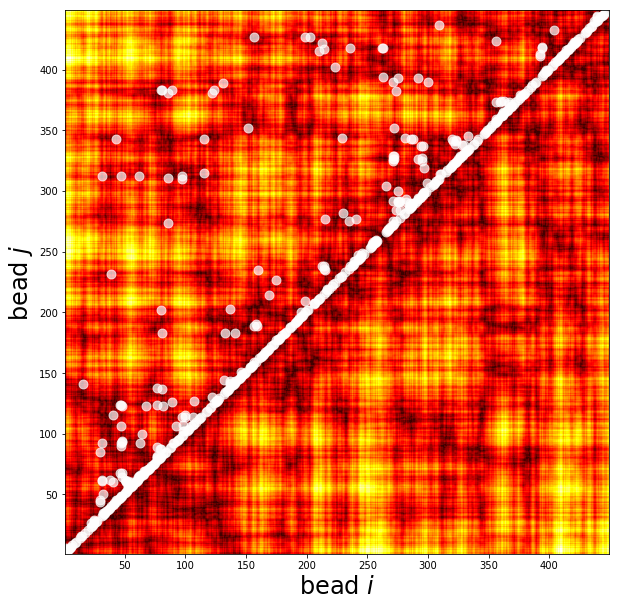

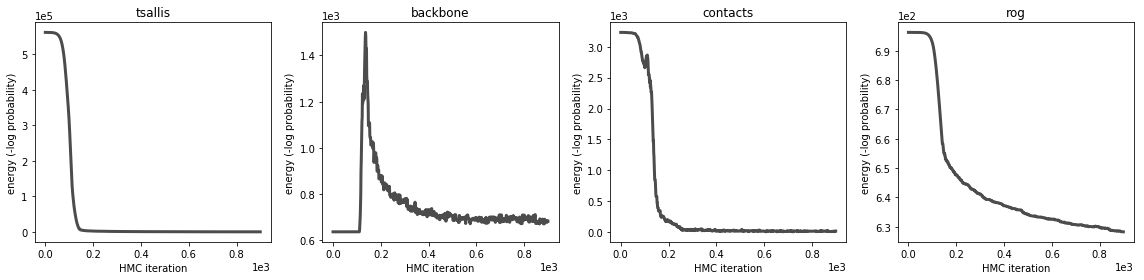

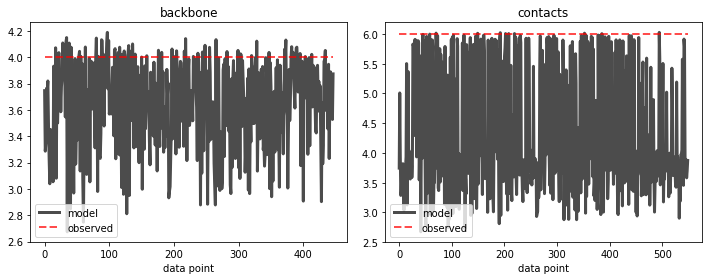

In [25]:
if __name__ == '__main__':
    
    #pymol = utils.ChainViewer()

    X = np.array([state.positions for state in samples_fine]).reshape(len(samples_fine),-1,3)
    V = np.array([state.potential_energy for state in samples_fine])
    K = np.array([state.kinetic_energy for state in samples_fine])

    ensemble = Ensemble(X)

    ## show distance matrix and superimpose contacts

    n_particles = X.shape[1]
    limits = (1,n_particles+1)

    burnin, thining = -500, 10
    burnin, thining = -100, 1
    
    fig, ax = plt.subplots(1,1,figsize=(10,10),subplot_kw=dict(xlim=limits,ylim=limits))
    ax.matshow(ensemble.average_distances(burnin,thining), cmap=cm.hot, origin='lower',extent=limits+limits)
    ax.scatter(*(1+np.transpose(list(posterior['contacts'].mock.pairs))), color='w', alpha=0.7, s=80)
    ax.xaxis.set_ticks_position('bottom')
    ax.set_xlabel(r'bead $i$', fontsize=24)
    ax.set_ylabel(r'bead $j$', fontsize=24)
    
    ## calculate energies and plot energy traces

    energies = ensemble.calculate_energies(posterior,burnin=100)

    fig, ax = plt.subplots(1,len(energies),figsize=(16,4), subplot_kw=dict(xlabel='HMC iteration'))

    for i, name in enumerate(energies.keys()):
        ax[i].plot(energies[name],color='k',lw=3,alpha=0.7)
        ax[i].set_ylabel('energy (-log probability)')
        ax[i].set_title(name)
        ax[i].xaxis.get_major_formatter().set_powerlimits((0, 1))
        ax[i].yaxis.get_major_formatter().set_powerlimits((0, 1))
        
    fig.tight_layout()

    ## plot observed and backcalculated data

    models = [model for model in posterior.likelihoods if len(model.data) > 1]

    fig, ax = plt.subplots(1,len(models),figsize=(10,4), subplot_kw=dict(xlabel='data point'))

    for i, model in enumerate(models):
        ax[i].plot(model.mock.get(),color='k',lw=3,alpha=0.7,label='model')
        ax[i].plot(model.data,color='r',lw=2,ls='--',alpha=0.7,label='observed')
        ax[i].set_title(model.name)
        ax[i].legend(loc=3)
        
    fig.tight_layout()

In [31]:
pymol(X)

In [27]:
"""
This script sets up the posterior probability of the structure of
the X chromosome based on single-cell Hi-C contact data. 
"""
from isdhic import HiCParser
from isdhic.chromosome import ChromosomeSimulation

## Each bead represents 50 Kb of chromatin and has a diameter of
## roughly 200 nm (assuming a chromatin density of 12 Mb / mu^3)

resolution  =     10 * 1e3
chrsize     = 22420 * 1e3
n_particles = int(chrsize / resolution)

## Linearly ramped Lennard-Jones potential preventing inter-bead
## clashes. The bead diameter is 4 and chosen for compatibility with
## settings used in protein simulations

forcefield  = 'rosetta'
diameter    = 4.

## Single-cell Hi-C data from Nagano et al., the contact distance
## is factor x diameter which equals to 6. Data are from cell 1

filename    = '../data/test.txt'
factor      = 1.5

## Beads-on-string-model: consecutive beads are connected by a
## harmonic potential with a flat bottom. The harmonic force
## becomes active when the distance between beads (i, i+1) exceeds
## the bead diameter. The force constant controls the strength of
## that force

k_backbone  = 250.

## Radius of gyration (rog) restraint derived from FISH data. The
## size of the X chromosome is roughly 2.58 x rog. Nagano et al.
## determined a size of 3.7 +/- 0.3 mu based on 10 FISH measurements

n_rog       = 10
mu_rog      = 3.7e3 / (2.58 * (resolution / 1200) / diameter)
sigma_rog   = 0.3e3 / (2.58 * (resolution / 1200) / diameter)
tau_rog     = n_rog / sigma_rog**2

## Read data and map chromosomal positions onto 500Kb beads and
## remove contacts arising from loci that are close in sequence and
## were mapped to the same bead.

parser      = HiCParser(filename, 'X', 'X')
datasets    = parser.parse()
dataset     = datasets[('X','X')]
model       = ('logistic', 'relu')[0]

dataset.coarsen(n_particles, chrsize)

dataset.remove_redundant_contacts()
dataset.remove_self_contacts()

## Set up posterior probability using the above settings

simulation  = ChromosomeSimulation(n_particles,
                                   forcefield = forcefield,
                                   k_backbone = k_backbone,
                                   diameter   = diameter,
                                   factor     = factor,
                                   contact_model = model)

posterior = simulation.create_chromosome(list(dataset))
universe  = simulation.universe
coords    = simulation.params['coordinates']
forces    = simulation.params['forces']

posterior['rog'].data[0] = mu_rog
posterior['rog'].tau     = tau_rog

In [32]:
"""
Continue HMC sampling at higher resolution.

This script assumes that 'run_hmc.py' has already been executed in
the *same* python session.
"""
import numpy as np

from scipy import interpolate

def lift_coords(coarse_coords, n_fine):
    """
    Interpolate 3d fiber with a finer sampling.
    """
    tck, u = interpolate.splprep(np.reshape(coarse_coords,(-1,3)).T)    
    coords = interpolate.splev(np.linspace(0,1,n_fine), tck)

    return np.transpose(coords).flatten()

if __name__ == '__main__':
    
    #resolution = 50
    #filename   = './chrX_cell1_{0}kb.py'.format(resolution)

    #with open(filename) as script:
    #    exec script

    coords.set(lift_coords(samples_fine[-1].positions, n_particles))

    ## use Hamiltonian Monte Carlo to sample X chromosome structures from the
    ## posterior distribution

    n_steps  = 1e3                           ## number of HMC iterations
    n_leaps  = 1e1                           ## number of leapfrog integration steps
    stepsize = 1e-7                          ## initial integration stepsize
    
    hmc_superfine = HamiltonianMonteCarlo(posterior,stepsize=stepsize)
    hmc_superfine.leapfrog.n_steps = int(n_leaps)
    hmc_superfine.adapt_until      = int(1e6) #0.5 * n_steps)
    hmc_superfine.activate()

    samples_superfine = []

    with take_time('running HMC'):
        while len(samples_superfine) < n_steps:
            samples_superfine.append(hmc_superfine.next())

n_steps = 20, acceptance rate = 100.0%, stepsize = 2.653e-07, -log_prob = 1.456e+05
n_steps = 40, acceptance rate = 100.0%, stepsize = 7.040e-07, -log_prob = 1.456e+05
n_steps = 60, acceptance rate = 100.0%, stepsize = 1.868e-06, -log_prob = 1.456e+05
n_steps = 80, acceptance rate = 100.0%, stepsize = 4.956e-06, -log_prob = 1.456e+05
n_steps = 100, acceptance rate = 100.0%, stepsize = 1.315e-05, -log_prob = 1.456e+05
n_steps = 120, acceptance rate = 100.0%, stepsize = 3.489e-05, -log_prob = 1.456e+05
n_steps = 140, acceptance rate = 100.0%, stepsize = 9.258e-05, -log_prob = 1.455e+05
n_steps = 160, acceptance rate = 100.0%, stepsize = 2.456e-04, -log_prob = 1.449e+05
n_steps = 180, acceptance rate = 100.0%, stepsize = 6.517e-04, -log_prob = 1.409e+05
n_steps = 200, acceptance rate = 100.0%, stepsize = 1.729e-03, -log_prob = 1.177e+05
n_steps = 220, acceptance rate = 100.0%, stepsize = 4.588e-03, -log_prob = 5.653e+04
n_steps = 240, acceptance rate = 99.6%, stepsize = 1.113e-02, -log_pr

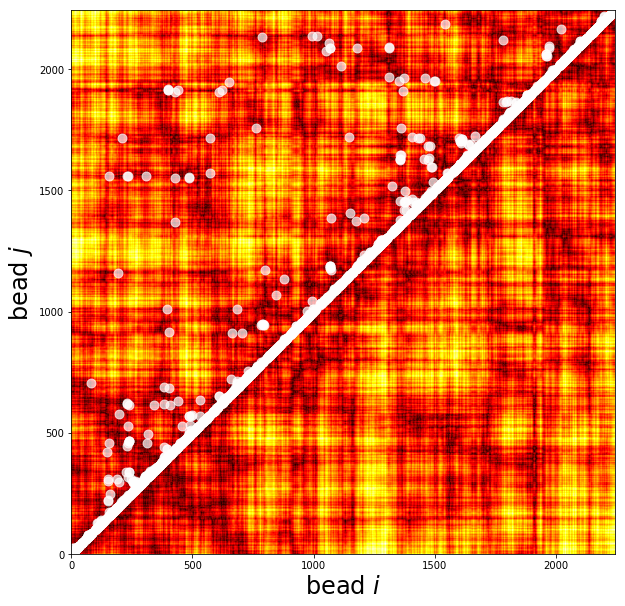

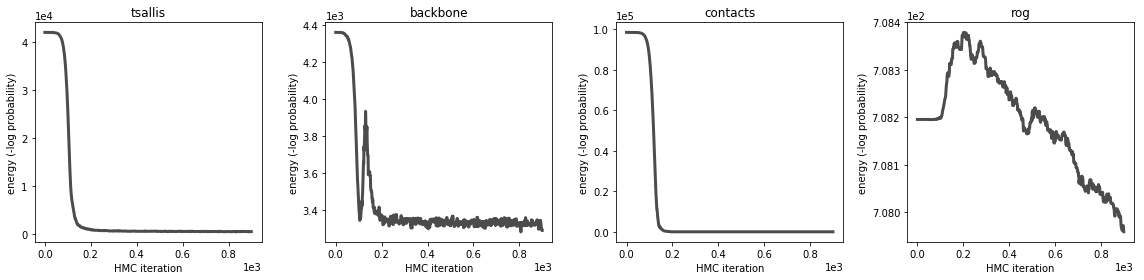

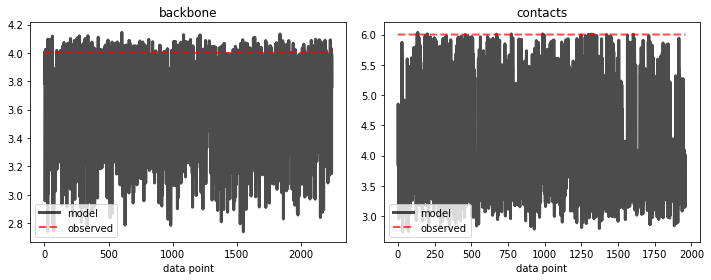

In [33]:
if __name__ == '__main__':
    
    #pymol = utils.ChainViewer()

    X = np.array([state.positions for state in samples_superfine]).reshape(len(samples_superfine),-1,3)
    V = np.array([state.potential_energy for state in samples_superfine])
    K = np.array([state.kinetic_energy for state in samples_superfine])

    ensemble = Ensemble(X)

    ## show distance matrix and superimpose contacts

    n_particles = X.shape[1]
    limits = (1,n_particles+1)

    burnin, thining = -500, 10
    burnin, thining = -100, 1
    
    fig, ax = plt.subplots(1,1,figsize=(10,10),subplot_kw=dict(xlim=limits,ylim=limits))
    ax.matshow(ensemble.average_distances(burnin,thining), cmap=cm.hot, origin='lower',extent=limits+limits)
    ax.scatter(*(1+np.transpose(list(posterior['contacts'].mock.pairs))), color='w', alpha=0.7, s=80)
    ax.xaxis.set_ticks_position('bottom')
    ax.set_xlabel(r'bead $i$', fontsize=24)
    ax.set_ylabel(r'bead $j$', fontsize=24)
    
    ## calculate energies and plot energy traces

    energies = ensemble.calculate_energies(posterior,burnin=100)

    fig, ax = plt.subplots(1,len(energies),figsize=(16,4), subplot_kw=dict(xlabel='HMC iteration'))

    for i, name in enumerate(energies.keys()):
        ax[i].plot(energies[name],color='k',lw=3,alpha=0.7)
        ax[i].set_ylabel('energy (-log probability)')
        ax[i].set_title(name)
        ax[i].xaxis.get_major_formatter().set_powerlimits((0, 1))
        ax[i].yaxis.get_major_formatter().set_powerlimits((0, 1))
        
    fig.tight_layout()

    ## plot observed and backcalculated data

    models = [model for model in posterior.likelihoods if len(model.data) > 1]

    fig, ax = plt.subplots(1,len(models),figsize=(10,4), subplot_kw=dict(xlabel='data point'))

    for i, model in enumerate(models):
        ax[i].plot(model.mock.get(),color='k',lw=3,alpha=0.7,label='model')
        ax[i].plot(model.data,color='r',lw=2,ls='--',alpha=0.7,label='observed')
        ax[i].set_title(model.name)
        ax[i].legend(loc=3)
        
    fig.tight_layout()

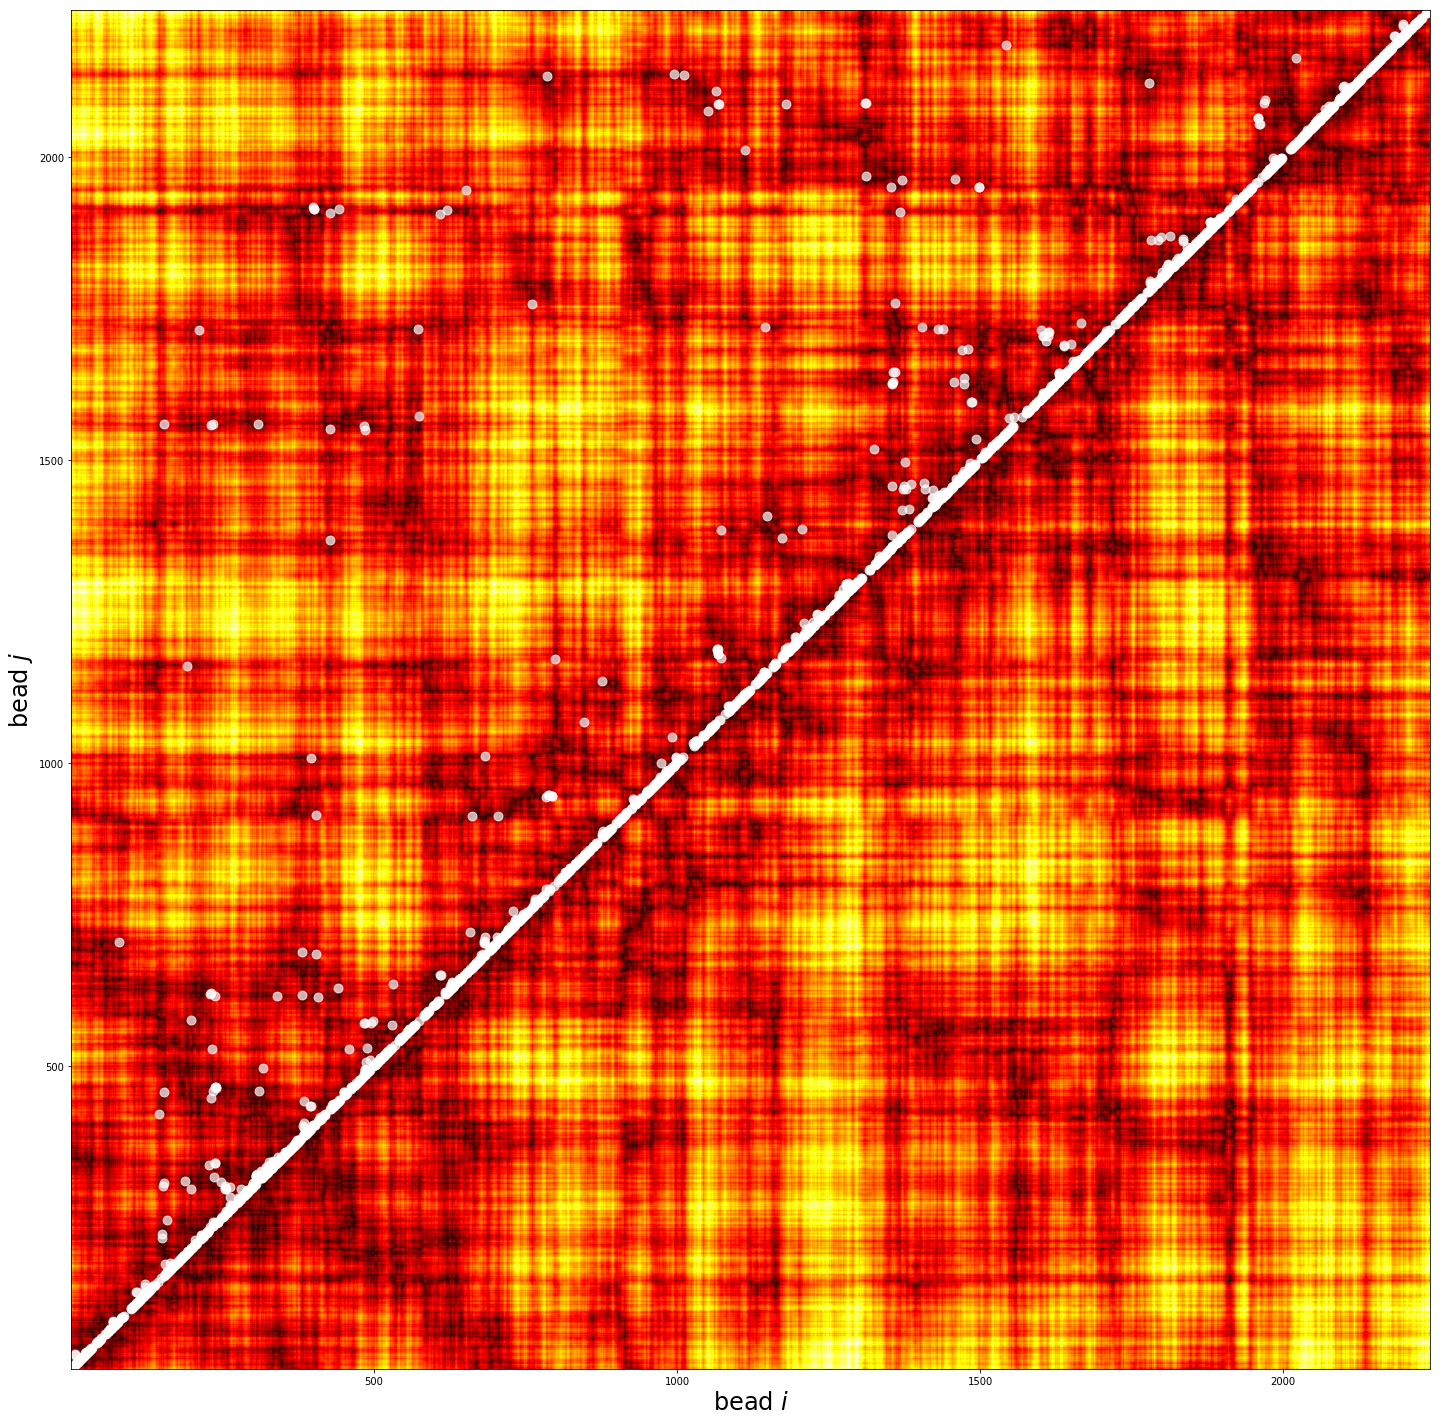

In [61]:
ensemble = Ensemble(X)

## show distance matrix and superimpose contacts

n_particles = X.shape[1]
limits = (1,n_particles+1)

burnin, thining = -500, 10
burnin, thining = -100, 1

fig, ax = plt.subplots(1,1,figsize=(25,25),subplot_kw=dict(xlim=limits,ylim=limits))
ax.matshow(ensemble.average_distances(burnin,thining), cmap=cm.hot, origin='lower',extent=limits+limits)
ax.scatter(*(1+np.transpose(list(posterior['contacts'].mock.pairs))), color='w', alpha=0.7, s=80)
ax.xaxis.set_ticks_position('bottom')
ax.set_xlabel(r'bead $i$', fontsize=24)
ax.set_ylabel(r'bead $j$', fontsize=24)

[]

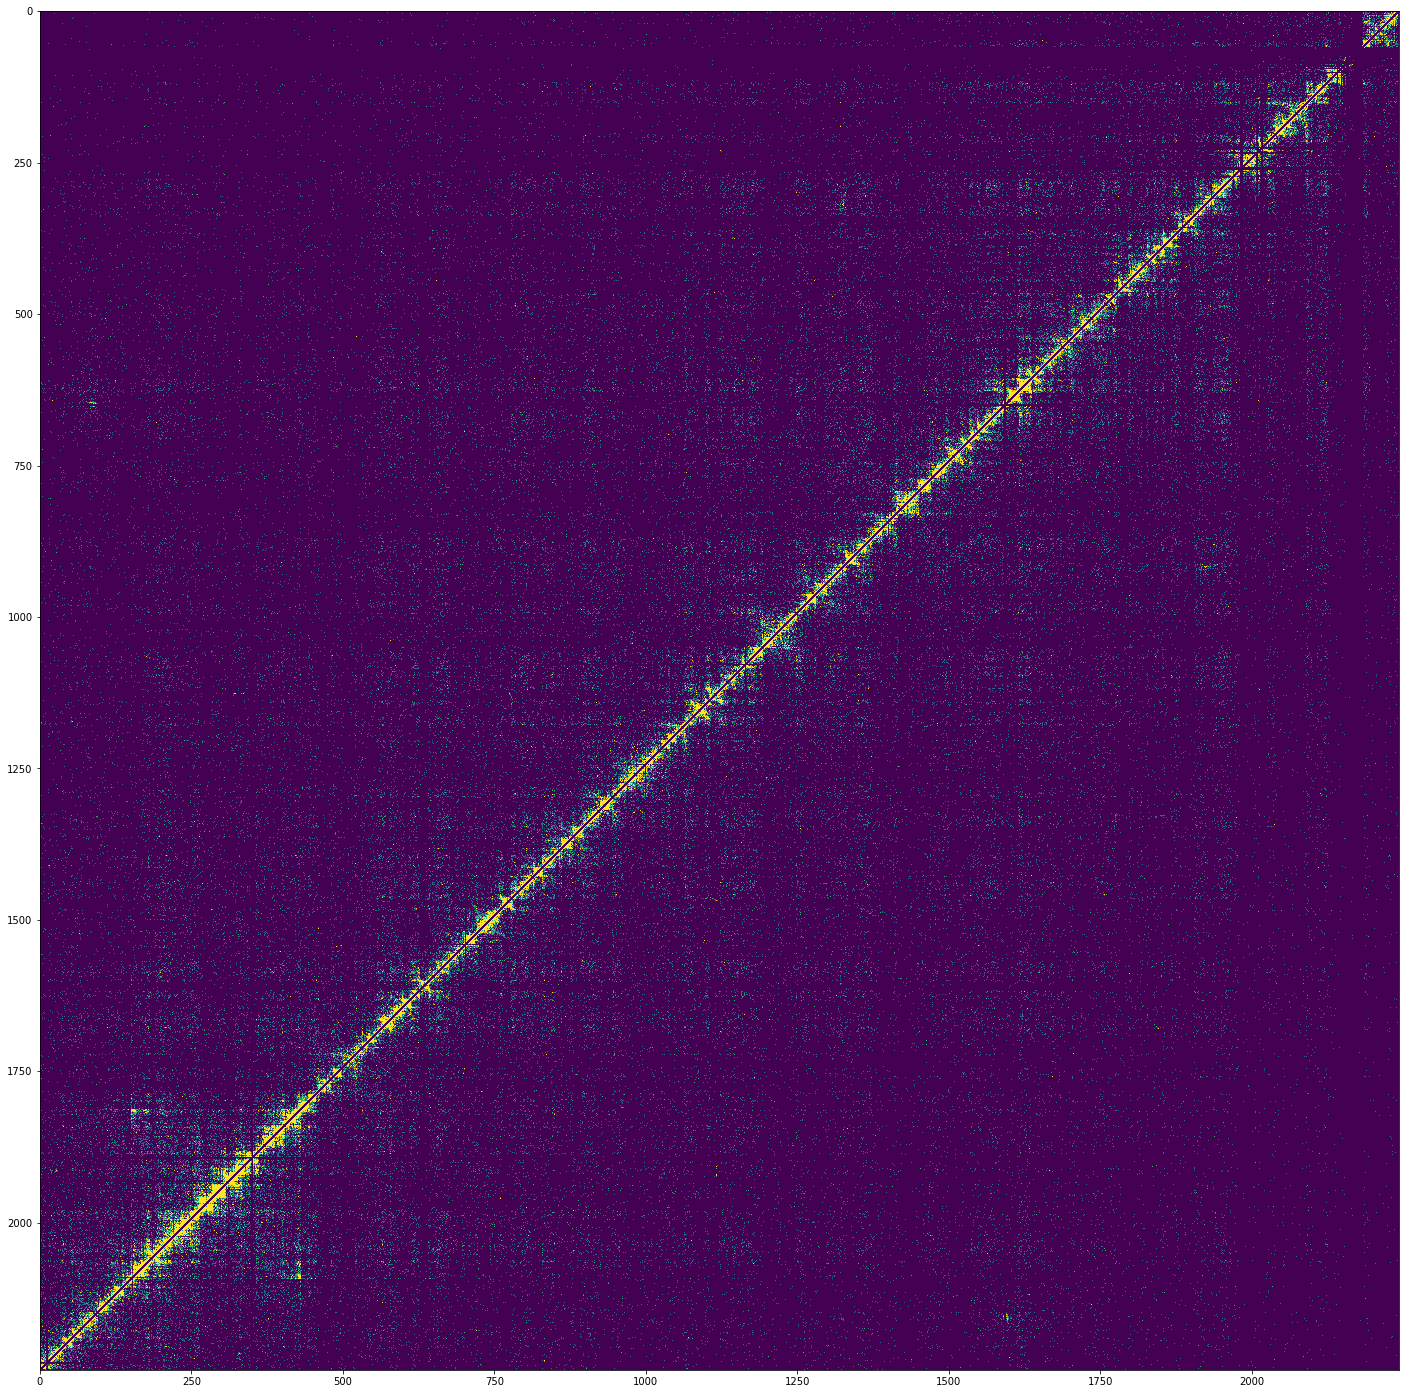

In [94]:
from scipy.sparse import coo_matrix

def remove_diag(arr, width=3):
    tmp = arr.copy()
    for i in range(arr.shape[0]):
        for j in range(width):
            if i+j < arr.shape[0]:
                tmp[i, i+j] = 0
            if i - j >= 0:
                tmp[i, i-j] = 0
    return tmp

c = cooler.Cooler('../../DATA/dm3/COOL/Dros.10.cool.full')
mtx = c.matrix(as_pixels=False, balance=False, sparse=False).fetch("chrX")

arr = remove_diag(mtx)

plt.figure(figsize=(25,25))
plt.imshow(np.flip(arr[:,:], 0).clip(0, 3))

#plt.imshow(-ensemble.average_distances(thining, burnin))
plt.plot()